In [1]:
## test model behavior in synthetic/real images.
## found model output one certain value after training.
## test general mse value

import os
from model import *
from data_loader import *
from utils import *
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import toy_utils
import torch.nn.functional as F
from helper_funcs import *

def load_checkpoint(ckpt_path, model):
    
    ckpt_dir = 'ckpt/'+ckpt_path

    print("[*] Loading model from {}".format(ckpt_dir))

    filename = 'rfc_model_best.pth.tar'
    ckpt_path = os.path.join(ckpt_dir, filename)
    ckpt = torch.load(ckpt_path)

    # load variables from checkpoint
    start_epoch = ckpt['epoch']
    best_loss = ckpt['best_valid_mse']
    print("current epoch: {} --- best loss: {}".format(start_epoch, best_loss))
    model.load_state_dict(ckpt['model_state'])
    #optimizer.load_state_dict(ckpt['optim_state'])   

    return model


In [2]:
model = focusLocNet(0.17, 1, 256, 2).to("cuda:0")

In [3]:
model = load_checkpoint('0507_16_13', model)

[*] Loading model from ckpt/0507_16_13
current epoch: 288 --- best loss: 0.668776384197207


In [4]:
model = model.eval()

In [5]:
def reset():
    h = [torch.zeros(1, 1, 256).cuda(),
                  torch.zeros(1, 1, 256).cuda()]
    l = torch.rand(1, 2).cuda()*2.0-1.0 #-0.5~0.5
    return h, l

In [6]:
video_path = "../datasets/DAVIS/test_davis_video_list.txt"
depth_path = "../datasets/DAVIS/test_davis_dpt_list.txt"
video_dataset = load_davis_dataset(video_path, depth_path, 4)[0]
dataiter = iter(video_dataset)

torch.Size([1, 4, 3, 1080, 1920])


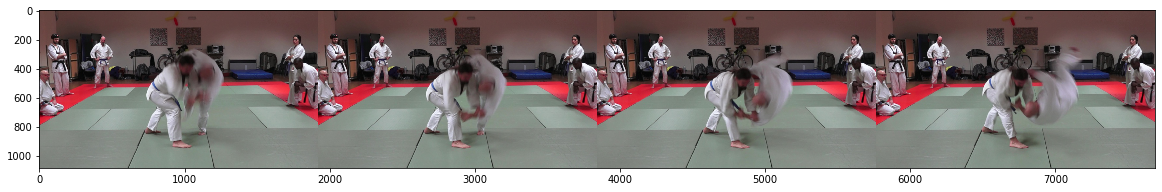

In [7]:
x_train, dpt = dataiter.next()
x_train = x_train.cuda()
dpt = dpt.cuda()
print(x_train.size())

# show images
imshow(torchvision.utils.make_grid(x_train[0]).cpu())


In [8]:
# plt.imshow(dpt[0][2][0].cpu())
# plt.colorbar()
# plt.show()

In [9]:
from awnet import pwc_5x5_sigmoid_bilinear   # cm:import AWnet model
import torch
from torchvision import transforms, utils

AWnet = pwc_5x5_sigmoid_bilinear.pwc_residual().cuda()
AWnet.load_state_dict(torch.load('awnet/fs_34_all_0.03036882.pkl'))
AWnet = AWnet.eval()

import warnings
warnings.filterwarnings("ignore")

def fuseTwoImages(I, J_hat):
    with torch.no_grad():
        fusedTensor,warp,mask = AWnet(J_hat,I)
    return fusedTensor, warp, mask

def patchize(img):
    imgs = []
    H, W, C = img.shape
    ph = H//2
    pw = W//2
    img_empty = np.zeros((H+200, W+200, C))
    img_empty[100:-100, 100:-100] = img
    img = img_empty
    for i in range(2):
        for j in range(2):
            imgs.append(img[100+ph*i-50:100+ph*i+ph+50, 100+pw*j-32:100+pw*j+pw+32])
    imgs = np.stack(imgs)
    return imgs

def depatchize(imgs, pd_h = 50, pd_w = 32):
    ph = (imgs[0].shape[0]-2*pd_h)
    pw = (imgs[0].shape[1]-2*pd_w)
    img = np.zeros((ph*2, pw*2, 3))
    for i in range(2):
        for j in range(2):
            img[i*ph:i*ph+ph, j*pw:j*pw+pw] = imgs[i*2+j, pd_h:-pd_h, pd_w:-pd_w]
            
    return img
    
def image_fuse(a_batch, b_batch):
    batch_size = a_batch.size(0)
    c_batch = []
    for k in range(batch_size):
        a = a_batch[k]
        b = b_batch[k]
        a = a.cpu().detach().numpy().transpose(1, 2, 0) /2. + 0.5
        b = b.cpu().detach().numpy().transpose(1, 2, 0) /2. + 0.5
        
        aa = patchize(a)
        bb = patchize(b)
        aa = torch.Tensor(aa.transpose(0, 3, 1, 2)).cuda()
        bb = torch.Tensor(bb.transpose(0, 3, 1, 2)).cuda()

        ccs = []
        #wws = []
        for i in range(4):
            cc, ww, mask = fuseTwoImages(aa[i:i+1], bb[i:i+1])
            ccs.append(cc[0])
            #wws.append(ww[0])
        cc = torch.stack(ccs)
        #ww = torch.stack(wws)

        c = depatchize(cc.cpu().detach().numpy().transpose(0, 2, 3, 1))
        #warp = depatchize(ww.cpu().detach().numpy().transpose(0, 2, 3, 1))
        c = np.clip(c, 0, 1) * 2 - 1.0
        c = torch.from_numpy(c.transpose(2, 0, 1)).cuda().float()
        c_batch.append(c)
        
    c_batch = torch.stack(c_batch)
    return c_batch

In [10]:
losses = []
print(len(video_dataset))
for i, (x_train, dpt) in enumerate(video_dataset):
    print(i)
    
    x_train = x_train.cuda()
    dpt = dpt.cuda()


    J_est = []
    I_est = []
    afs = []
    locs = []
    J_prev = None
    last_af = None
    h, l = reset()
    l = torch.zeros(1, 2).cuda()#*2.0-1.0
    with torch.no_grad():
        for t in range(x_train.size(1)):

            I, af, u_in  = getDefocuesImage(l, x_train[:, t, ...], dpt[:, t, ...])
            if J_prev is None:
                J_prev = I
            else:
                ## needs blockwise op
                J_prev = image_fuse(I, J_prev)

            I_est.append(I)
            J_est.append(J_prev)


            if last_af is None:
                input_t = af
            else:
                input_t = torch.min(af, last_af)
            last_af = af

            afs.append(input_t)
            h, l = reset()

            #h, mu, l, _, _ = model(input_t, l, h)
            

            locs.append(l)

        J_est = torch.stack(J_est, dim = 1)
        I_est = torch.stack(I_est, dim = 1)
        afs = torch.stack(afs, dim = 1)
        locs = torch.stack(locs, dim = 1)
    losses.append(F.mse_loss(J_est, x_train).item())
# print("mse loss: ", F.mse_loss(J_est, x_train).item())
# imshow(torchvision.utils.make_grid(color_region(I_est[0], locs[0])).cpu())
# # imshow(torchvision.utils.make_grid(U_est[0]).cpu())
# imshow(torchvision.utils.make_grid(J_est[0]).cpu())
# imshow(torchvision.utils.make_grid(afs[0]).cpu())
# imshow(torchvision.utils.make_grid(x_train[0]).cpu())


4967
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

AssertionError: 

In [11]:
sum(losses)/len(losses)

0.0018867224698474012